# Predicting Taiwan Semiconductor Manufacturing Company Stock (NYSE: TSM) Using Historical Stock Data

<h1>Table of Contents</h1>
<ul>
  <li><a href="#Background-Information">Background Information</a></li>
  <li><a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a></li>
<li><a href="#Model-Selection-And-Training">Model Selection and Training</a></li>
  <li><a href="#Performance-Evaluation">Performance Evaluation</a></li>
  <li><a href="#Conclusion">Conclusion</a></li>
  <li><a href="#References">References</a></li>
  <li><a href="#Appendices">Appendices</a></li>
</ul>

<h2 id="Background-Information">Background Information</h2>

Project Overview:

In this project, we predict TSMC's stock price using advanced time-series models, LSTM and ARIMA, known for capturing temporal patterns in stock forecasting. We are conducting this project to provide actionable insights by leveraging forecasting models to enhance decision-making, as understanding TSMC's stock price offers valuable perspectives on trends and dynamics in the rapidly growing AI market. Our approach includes TSMC as a key predictor, alongside Nvidia, the Taiwan Stock Index, and the S&P 500, as recommended by ChatGPT. Using TSMC's historical data follows standard practices in stock prediction. By leveraging LSTM's ability to recognize long-term dependencies and ARIMA's strength in linear trend modeling, we aim to create accurate predictions and compare their performance, highlighting the power of machine learning and statistical methods in financial forecasting.

Company Overview:

TSMC (Taiwan Semiconductor Manufacturing Company) is the global leader in advanced semiconductor manufacturing, critical for powering AI, high-performance computing, and cutting-edge technologies. (Taiwan Semiconductor Manufacturing Company, n.d.)

In [18]:
# Installing libraries
!pip install yfinance
!pip install statsmodels
!pip install tensorflow

In [19]:
# Downloading Necessary Libraries
import yfinance as yf #(Ran, 2019)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from statsmodels.tsa.api import VAR
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Importing the Data (from yfinance):

It is important to keep most of the data, as some missing values in one stock may not mean that other stocks have those missing values.

In [20]:
# Import TSM (Taiwan Semiconductor Manufacturing Company), NVDA (Nvidia), TAIEX (Taiwan Stock Index), and .INX (US S&P 500 Index)

# Create a list of stock tickers
tickers = ["TSM",   # Taiwan Semiconductor Manufacturing Company
           "NVDA",  # Nvidia
           "^TWII", # Taiwan Stock Exchange Index
           "^GSPC"] # S&P 500

# Fetch historical data from Yahoo Finance
data = yf.download(tickers, start='2014-12-01', end='2024-12-01')

# Align all stock data to closing time for consistency
data = data['Adj Close']
data = data.sort_index()  # Sort by date
data.columns = ["TSM", "NVDA", "TAIEX", "S&P 500"] # Rename columns

# Show data head
data.head()

[*********************100%***********************]  4 of 4 completed


,TSM,NVDA,TAIEX,S&P 500
Date,,,,
2014-12-01,0.493944,17.410343,2053.439941,9117.667969
2014-12-02,0.494664,17.129532,2066.550049,9034.749023
2014-12-03,0.507385,17.402754,2074.330078,9175.217773
2014-12-04,0.502824,17.319267,2071.919922,9225.068359
2014-12-05,0.505705,17.258556,2075.370117,9206.528320


In [21]:
# Checking for missing values
missing_values = data.isna().sum().sum()
total_values = data.size
missing_percentage = (missing_values / total_values) * 100
print(missing_percentage)

# Check for average number of days between missing values

# Firstly, identify missing values
missing_dates = data.isna()
# Create a list of missing gaps, where each value is the number of days between valid data
missing_gaps = []

# Iterate over dataset
i = 0
while i < len(data):
    # Check if the current day is missing
    if missing_dates.iloc[i].any():
        missing_count = 1  # Start counting the missing day
        # Iterate over the next days until we find a valid day
        while i + 1 < len(data) and missing_dates.iloc[i + 1].any():
            missing_count += 1
            i += 1
        # After finding a valid day, store the gap (number of missing days)
        missing_gaps.append(missing_count)
    i += 1

average_gap = sum(missing_gaps) / len(missing_gaps)
print(f"Average number of consecutive missing days: {average_gap}")

3.8342967244701347
Average number of consecutive missing days: 1.5316455696202531


Because average distance is only 1.53 days, we have chosen to move forward with linear fill, as it allows more insight than forward fill by bridging the missing gap bewteen valid data.

In [22]:
# Data Cleaning
# Interpolate missing values
data = data.interpolate(method='linear')

<h2 id="Exploratory-Data-Analysis">Exploratory Data Analysis</h2>

Firstly, we visualize the historical adjusted close prices of TSMC, Nvidia, TAIEX, and S&P 500 from 2014 to 2024 to provide an overview of their performance trends. Specifically, we chose NVIDIA, TSMC’s second-largest customer, as a predictor instead of Apple because NVIDIA's reliance on advanced technologies, rapid revenue growth, and sensitivity to dynamic, high-growth markets make it a more impactful and forward-looking indicator of TSMC’s stock price (ChatGPT, 2024).

We used GenAI to help us compare potential predictors for TSMC’s stock price by looking at its major customers, like NVIDIA and Apple. It helped us understand NVIDIA’s strong reliance on TSMC’s technology, rapid growth, and sensitivity to high-growth markets, which made it clear why NVIDIA would be a better choice as a predictor.

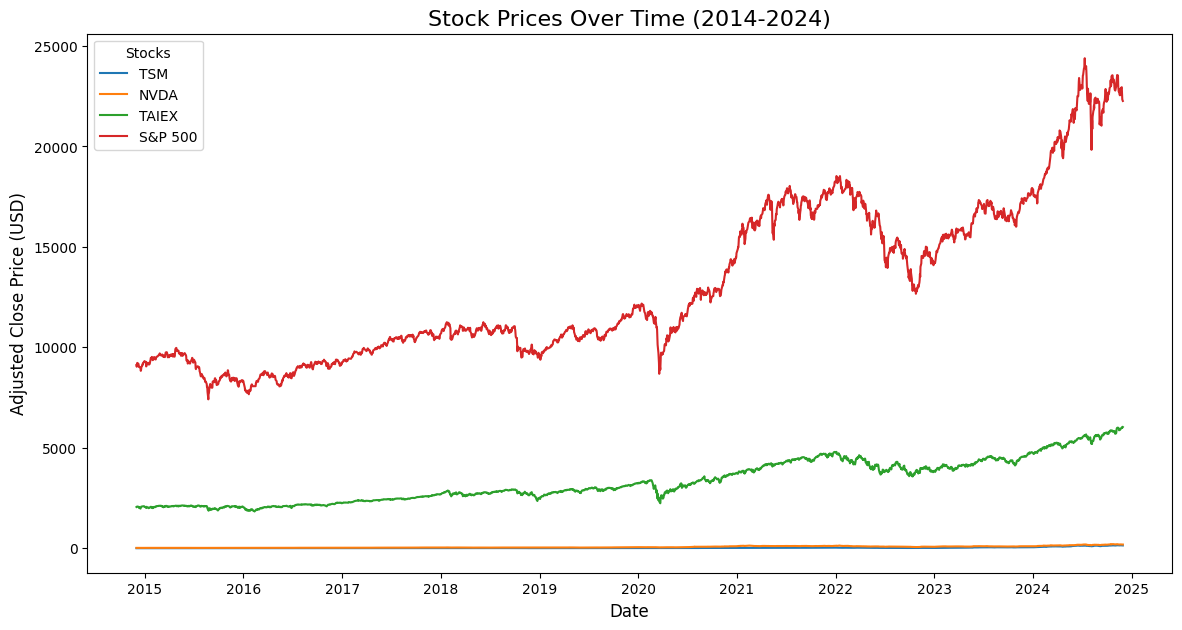

In [23]:
# Plot the stock prices over time
plt.figure(figsize=(14, 7))

for column in data.columns:
    plt.plot(data.index, data[column], label=column)

# Add title and labels
plt.title('Stock Prices Over Time (2014-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price (USD)', fontsize=12)

# Add legend and show plot
plt.legend(title="Stocks", fontsize=10)
plt.show()

The output is a multi-line plot showing the historical trends in adjusted close prices for TSMC, Nvidia, TAIEX, and the S&P 500 over the time period 2014 to 2024. However, the differences in price ranges make relationships between variables harder to see. Hence, we need to normalize the data using Min-Max scaling resolves this issue, enabling clearer visual and analytical comparisons.

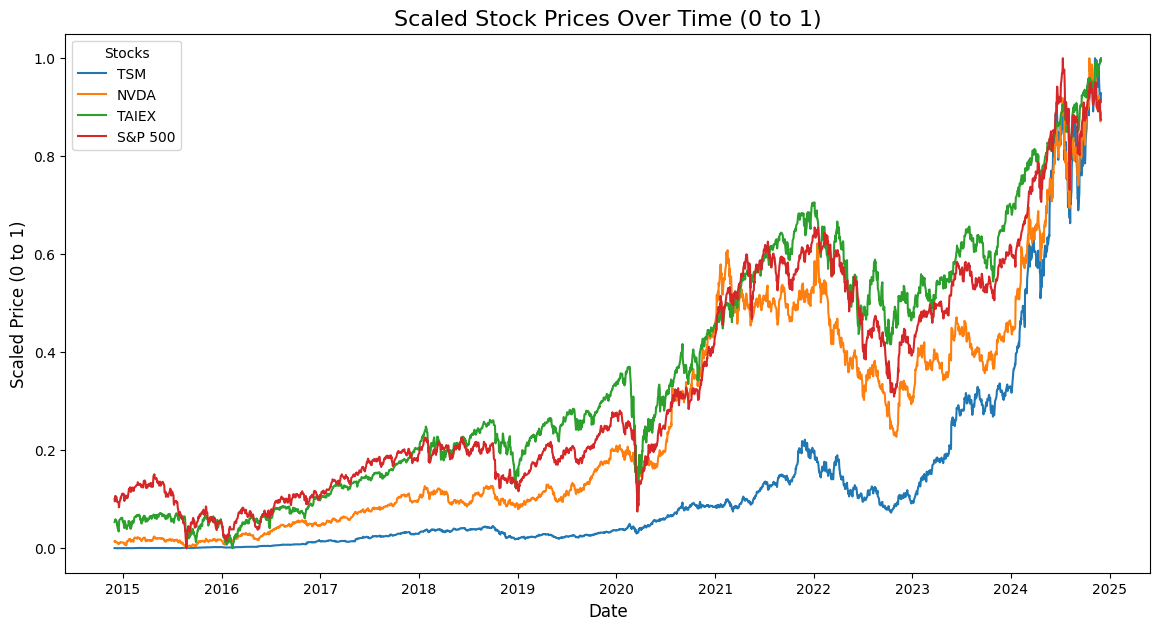

In [24]:
# Initialise scaler
scaler = MinMaxScaler()

# Scale data, ensuring that we scale per column and not as a whole
scaled_data = scaler.fit_transform(data.values)

# Create a new scaled dataframe
scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

# Create plot
plt.figure(figsize=(14, 7))

for column in scaled_df.columns:
    plt.plot(scaled_df.index, scaled_df[column], label=column)

plt.title('Scaled Stock Prices Over Time (0 to 1)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Scaled Price (0 to 1)', fontsize=12)

plt.legend(title="Stocks", fontsize=10)
plt.show()

The "Scaled stock Prices Over Time" shows the scaled stock prices of TSMC, Nvidia, TAIEX, and the S&P 500 from 2014 to 2024, with the prices normalized to a range of 0 to 1. The scaling enables direct comparison across the stocks and indices, eliminating the influence of their differing original price ranges. Nvidia demonstrates steep growth, particularly after 2020, reflecting its success in AI hardware, while TSMC exhibits consistent and steady growth, showcasing its importance in semiconductor manufacturing. TAIEX and S&P 500 highlight broader market trends, including the sharp dip in 2020 caused by the global pandemic, followed by a strong recovery.

Further, we can conduct feature engineering on the scaled dataset by converting it into percentage growth to discover trends in growth over time.

In [25]:
# Convert Scaled data into percentage data
growth_df = data.pct_change() * 100

# Drop NA values as first and last day will not have growth data
growth_df.dropna(inplace=True)

                 TSM      NVDA     TAIEX   S&P 500
Date                                              
2014-12-02  0.145813 -1.612899  0.638446 -0.909432
2014-12-03  2.571511  1.595035  0.376474  1.554761
2014-12-04 -0.898760 -0.479732 -0.116190  0.543318
2014-12-05  0.572831 -0.350540  0.166522 -0.200975
2014-12-08 -1.281499 -1.055418 -0.725657 -0.209420


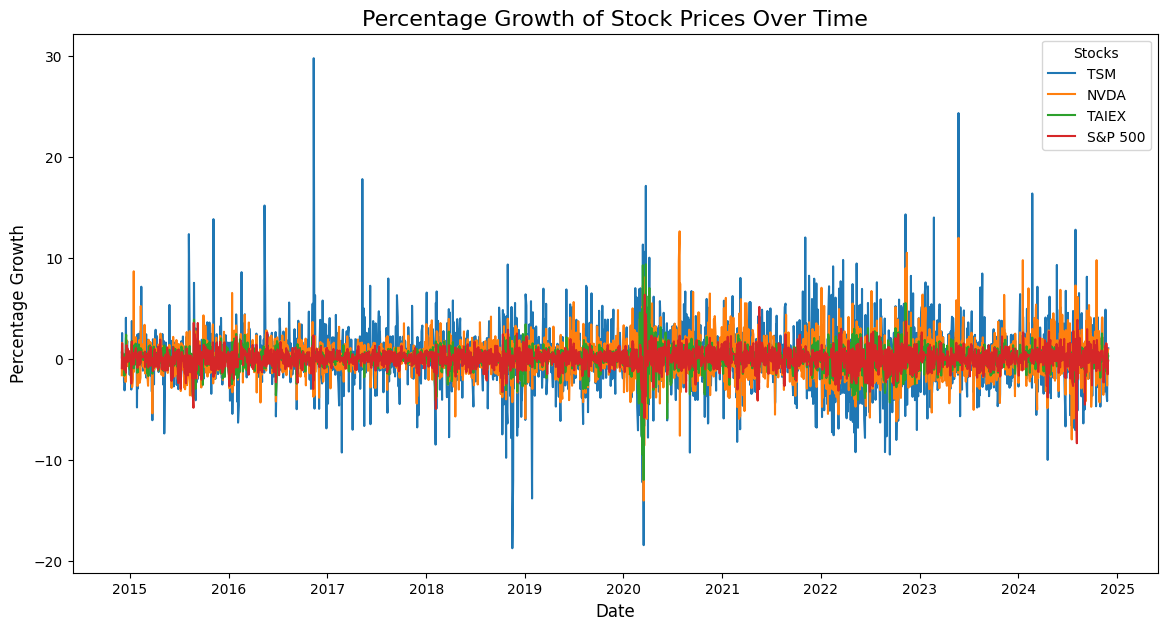

In [26]:
# Display the first few rows of the growth DataFrame
print(growth_df.head())

# Plot the percentage growth data
plt.figure(figsize=(14, 7))

for column in growth_df.columns:
    plt.plot(growth_df.index, growth_df[column], label=column)

plt.title('Percentage Growth of Stock Prices Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage Growth', fontsize=12)

plt.legend(title="Stocks", fontsize=10)
plt.show()

This graph shows the daily percentage growth of TSMC, Nvidia, TAIEX, and S&P 500 from 2014 to 2024. TSMC and Nvidia exhibit higher volatility, with sharp spikes reflecting market dynamics. Increased fluctuations in 2020 highlight the market instability during the COVID-19 pandemic, followed by moderated but persistent variability, particularly for TSMC and Nvidia. This highlights the risks and trends in stock price changes over time.

               TSM         NVDA        TAIEX      S&P 500
count  2594.000000  2594.000000  2594.000000  2594.000000
mean      0.261651     0.110122     0.047608     0.038967
std       2.990879     1.956379     1.098220     0.952059
min     -18.755845   -14.034116   -11.984055    -8.351980
25%      -1.183233    -0.925031    -0.358334    -0.402289
50%       0.253717     0.078639     0.054201     0.085508
75%       1.704512     1.068564     0.559971     0.538112
max      29.806717    12.652228     9.382774     6.367105


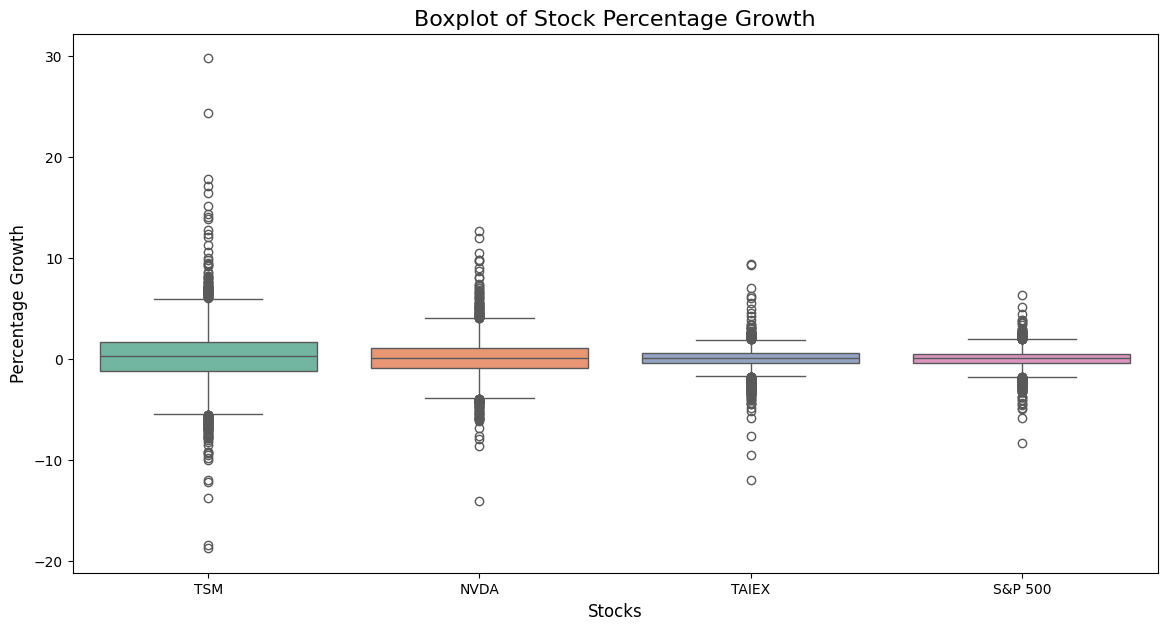

In [27]:
# Summary of dataframe

# Generate summary statistics for the growth_df (percentage growth)
growth_summary = growth_df.describe()
print(growth_summary)

# Create a boxplot
plt.figure(figsize=(14, 7))

sns.boxplot(data=growth_df, palette='Set2')

plt.title('Boxplot of Stock Percentage Growth', fontsize=16)
plt.xlabel('Stocks', fontsize=12)
plt.ylabel('Percentage Growth', fontsize=12)

plt.show()

Explanation of Summary Statistics:

Percentage growth is used instead of scaled data as it captures daily changes, offering insights into typical growth rates, volatility, and extremes, which scaled data cannot provide. Metrics like the mean and standard deviation highlight the average performance and variability of each stock or index.

Description of Boxplot:

The boxplot shows the distribution of percentage growth for TSMC, Nvidia, TAIEX, and S&P 500. TSMC and Nvidia exhibit greater volatility, with outliers representing significant market events.

Outliers reflect real market phenomena like earnings reports or economic events. Removing them would reduce the model's ability to capture the full scope of market behavior.

Further, we will create a correlation matrix to explore relationships between variables, check for multicollinearity, and provide insight for feature selection.

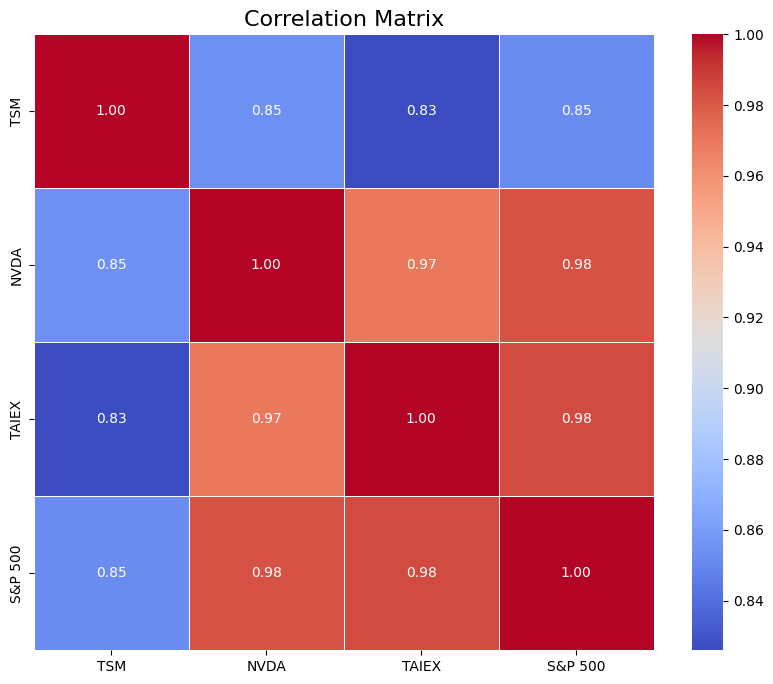

In [28]:
# Calculate the correlation matrix
correlation_matrix = scaled_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Explanation of Correlation Matrix:

The correlation matrix shows strong positive relationships between TSMC, NVDA, TAIEX, and the S&P 500, indicating shared market trends. We keep NVDA, TAIEX, and S&P 500 as predictors due to their strong correlations with TSMC. Despite multicollinearity, all variables are retained since stock prices often reflect broader market movements, ensuring the model captures these dynamics effectively.

<h2 id="Model-Selection-And-Training">Model Selection and Training</h2>

We have chosen to move forward with LSTM and ARIMA models, as both are well-suited for time-series forecasting. LSTM, a neural network model, excels in capturing long-term dependencies and sequential patterns, while ARIMA is effective for modeling linear trends and seasonality in the data. Our training includes TSM as a target variable and predictors such as NVDA, S&P 500, TAIEX, and TSM itself, which are commonly used in stock prediction models. Our assumptions:

Historical trends will influence future prices.
Stock prices follow patterns that can be captured by linear or sequential models.
The modeling process involves several key steps. Firstly, we preprocess the data through normalization and feature engineering to ensure consistency across variables. Next, we implement a single-step sampler function for preparing the time-series input-output pairs, allowing the LSTM model to capture temporal relationships effectively. The ARIMA model is trained on historical differenced data to stabilize trends and capture linear dependencies. Finally, predictions from both models are evaluated using metrics like MSE, MAE, and R² to compare their performance.

We used GenAI to assist with model selection and training by generating code for implementing both LSTM and ARIMA models with default parameters. This helped streamline the initial setup process, allowing us to focus on fine-tuning and evaluating the models' performance.

Firstly, we need to create a single step sampler function (GeeksforGeeks, n.d.; Machine Learning Mastery, n.d.).

In [29]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
              # Features for each column
              r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df['TSM'].iloc[i + window])  # Target is TSM
    return np.array(xRes), np.array(yRes)

Below, we split the data into training and test groups using an 85:15 ratio. This split is commonly used in stock prediction as it provides ample data for training while reserving enough unseen data to prevent overfitting and ensure reliable testing (Kumbure et al., 2022).

In [30]:
# Define the time window for LSTM
window_size = 20

# Prepare the dataset using the singleStepSampler function
xVal, yVal = singleStepSampler(scaled_df, window_size)

# Split the dataset using train_test_split
# Shuffle is set as false as it is a time series data
X_train, X_test, y_train, y_test = train_test_split(xVal, yVal, test_size=0.15, random_state=42, shuffle=False)

Define and Train LSTM Model:

We rescaled the data to improve the legibility and interpretability of the results. The input data was normalized using Min-Max scaling to bring all features into the same range, ensuring consistent scaling for the LSTM model. It helped the model to train on this normalized data, and to make sense of these predictions, we need to rescale it back to the original price range by applying ratios to both the predicted prices and the actual prices.

In [32]:
# Define LSTM model using default parameters
multivariate_lstm = Sequential([
    LSTM(128, activation='tanh', input_shape=(window_size, X_train.shape[2])),
    Dense(1)  # However, we need to tweak this paramater as we need it for our continuous data
])

# Set at default values as per brief
multivariate_lstm.compile(optimizer='adam', loss='mean_squared_error')

history = multivariate_lstm.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0, verbose=1)

# Predict
predicted_values = multivariate_lstm.predict(X_test)

# Reload the data with the date index
scaled_df.index = pd.to_datetime(scaled_df.index)

# Create a dataframe of predictions and actuals
d = {
    'Predicted Price': predicted_values.flatten(),
    'Actual Price': y_test,
}
d = pd.DataFrame(d)
d.index = scaled_df.index[-len(y_test):]  # Assigning the correct date index

# Convert scaled data back to actual prices

# Align y_test (Scaled TSM) indicies with actual TSM indicies to figure out ratio
actual_close_prices = data['TSM'].iloc[-len(y_test):].values
ratios = actual_close_prices / y_test

# Apply ratios to d
d['Predicted Price'] = d['Predicted Price'] * ratios
d['Actual Price'] = d['Actual Price'] * ratios

/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0012
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Plotting LSTM Model:

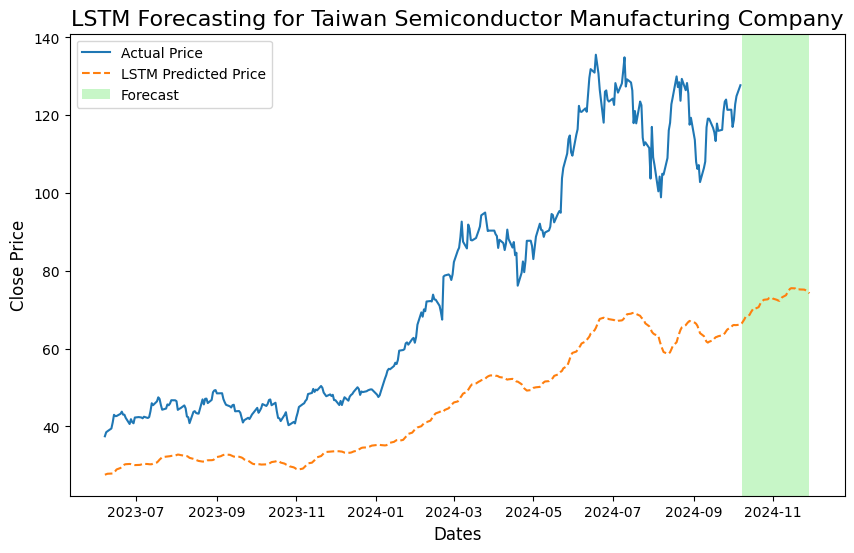

In [33]:
# Plot forecast with Dates on X-axis
fig, ax = plt.subplots(figsize=(10, 6))

highlight_start = int(len(d) * 0.9)  # Highlight 10% for forecasting
highlight_end = len(d) - 1  # Adjusted to stay within bounds

# Plot the actual values
plt.plot(d['Actual Price'][:highlight_start], label='Actual Price')

# Plot predicted values with a dashed line
plt.plot(d['Predicted Price'], label='LSTM Predicted Price', linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('LSTM Forecasting for Taiwan Semiconductor Manufacturing Company', fontsize=16)
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
ax.legend()
plt.show()

The LSTM predictions closely align with the actual price trends, showing the model's capability to capture the underlying patterns and seasonality of the stock price movements for TSMC. This alignment proves that the LSTM effectively learns from historical data to anticipate future price behavior. However, there is a slight lag in the predicted values compared to the actual prices, which suggests the model may struggle to react quickly to sudden market fluctuations. In the forecasted period (shaded in green), the predictions extend the established trend, offering a plausible projection of future prices, although further validation against unseen data is necessary to assess the model's reliability.

For the multivariate ARIMA model (Vector Autoregression) (GeeksforGeeks, n.d.; CloudZilla, n.d.; Analytics Vidhya, 2018), we split the data into training and testing sets to evaluate the model's performance. The training set is used to fit the VAR model, while the test set is used to assess its forecasting ability. Additionally, we applied scaling to normalize the data before modeling, as the VAR model requires stationary data. To achieve stationarity, we performed differencing on the data, which removes trends and makes the series suitable for forecasting.

In [34]:
data_diff = scaled_df.diff()

# Splitting
train_size = int(len(scaled_df) * 0.85)  # 85% for training, 15% for testing
train_data, test_data = scaled_df[:train_size], scaled_df[train_size:]

Define and Train ARIMA Model:

In [35]:
# Define VAR model with default parameters
model = VAR(train_data)
# Fit the VAR model using default parameters
results = model.fit()

# Predict using the fitted model
predicted = results.forecast(train_data.values[-results.k_ar:], steps=len(test_data))

# Convert forecast to DataFrame
predicted_df = pd.DataFrame(predicted, index=test_data.index, columns=test_data.columns)

# Prepare data for plotting (comparing predicted vs actual)
d_var = {
    'Predicted Price': predicted_df['TSM'],  # Using 'TSM' as the variable to forecast
    'Actual Price': test_data['TSM']
}

d_var = pd.DataFrame(d_var)
d_var.index = test_data.index  # Ensure correct Date index

# Reverse the differencing
d_var['Predicted Price'] = np.cumsum(d_var['Predicted Price'].values, axis=0)
d_var['Actual Price'] = np.cumsum(d_var['Actual Price'].values, axis=0)

# Rescale the data (as data is scaled) as previously done
actual_prices = data['TSM'].iloc[-len(d_var):].values
ratios = actual_prices / d_var['Actual Price'].values

# Apply ratios to d
d_var['Predicted Price'] = d_var['Predicted Price'] * ratios
d_var['Actual Price'] = d_var['Actual Price'] * ratios

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Plot ARIMA/VAR:

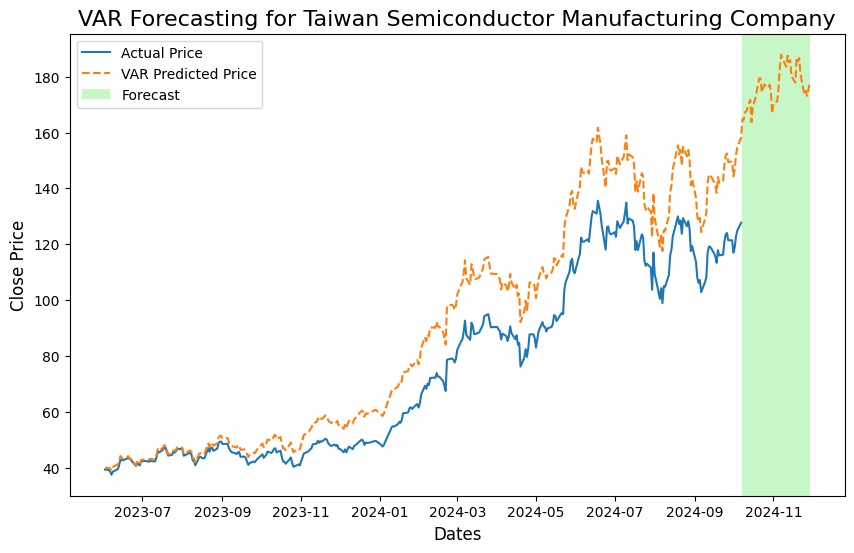

In [36]:
# Plot forecast with Dates on X-axis
fig, ax = plt.subplots(figsize=(10, 6))

highlight_start = int(len(d_var) * 0.9)  # Highlight 10% for forecasting
highlight_end = len(d_var) - 1  # Adjusted to stay within bounds

# Plot the actual values
plt.plot(d_var['Actual Price'][:highlight_start], label='Actual Price')

# Plot predicted values with a dashed line
plt.plot(d_var['Predicted Price'], label='VAR Predicted Price', linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d_var.index[highlight_start], d_var.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('VAR Forecasting for Taiwan Semiconductor Manufacturing Company', fontsize=16)
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
ax.legend()
plt.show()

This chart shows the VAR model's performance in forecasting TSMC's stock price. The model's predictions (orange dashed line) closely match actual prices (blue line), demonstrating its ability to capture trends. The data was scaled using Min-Max normalization before training and rescaled after prediction for accurate financial comparison.

The green-shaded area highlights the forecast period, where the model extrapolates from historical patterns. While the forecast reflects an upward trend, further validation on unseen data and performance evaluation are needed.

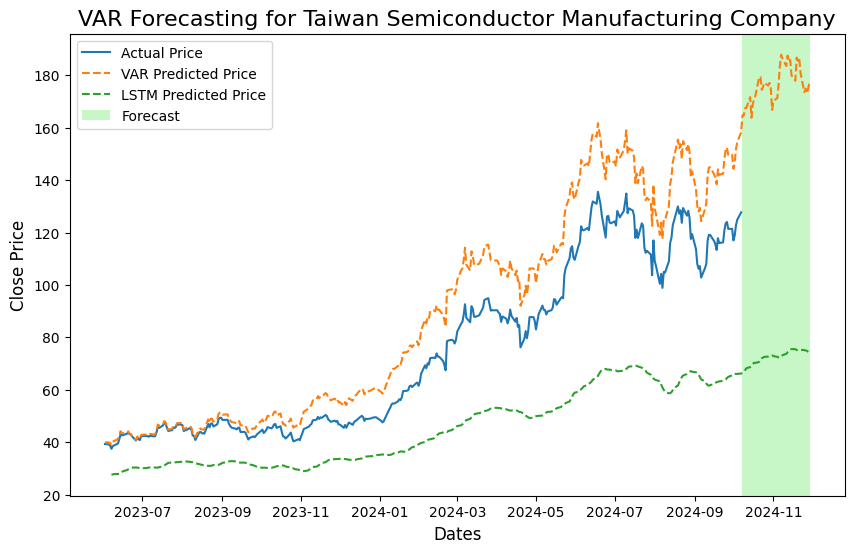

In [37]:
# Create new dataframe with both VAR/ARIMA and LSTM

# Create a copy of the dataframe, rename a column, and add LSTM from d
d_combined = d_var.copy()
d_combined.rename(columns={"Predicted Price": "VAR Predicted Price"}, inplace=True)
d_combined['LSTM Predicted Price'] = d['Predicted Price'].copy()
d_combined = d_combined.drop('Actual Price', axis=1)

# Plot forecast with Dates on X-axis
fig, ax = plt.subplots(figsize=(10, 6))

highlight_start = int(len(d_var) * 0.9)  # Highlight 10% for forecasting
highlight_end = len(d_var) - 1  # Adjusted to stay within bounds

# Plot the actual values
plt.plot(d_var['Actual Price'][:highlight_start], label='Actual Price')

# Plot predicted values with a dashed line
for column in d_combined.columns:
    plt.plot(d_combined.index, d_combined[column], label=column, linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d_combined.index[highlight_start], d_combined.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('VAR Forecasting for Taiwan Semiconductor Manufacturing Company', fontsize=16)
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
ax.legend()
plt.show()

Description of VAR Graph:

The graph compares actual TSMC stock prices with predictions from VAR and LSTM models.

Findings: Nvidia's steep growth post-2020, fueled by the AI boom (inferred from the Scaled Stock Prices Over Time plot), significantly influenced TSMC’s stock, highlighting the strong relationship between key predictors and TSMC’s performance. This connection is further supported by the combined plot comparing VAR and LSTM predictions, where both models capture TSMC's general upward trend but struggle during volatile periods. The 2020 market dips caused by COVID-19 exposed both models' limitations in handling abrupt, unpredictable market shocks, underscoring the challenges of accurate forecasting in highly volatile conditions.

VAR Model: Stronger at capturing short-term dynamics and price volatility, but it may sometimes overreact to fluctuations.

LSTM Model: Better at predicting general trends but less responsive to sudden changes, leading to smoother and less accurate predictions during volatile periods.

Forecast Implications: The LSTM is more conservative, whereas VAR suggests higher volatility in the future, potentially making it more suited for short-term trading decisions.

<h2 id="Performance-Evaluation">Performance Evaluation</h2>

LSTM Evaluation

In [38]:
# Evaluate the performance of the model
def eval(actual, predicted):
    return {
        'MSE': mean_squared_error(actual, predicted),
        'MAE': mean_absolute_error(actual, predicted),
        'R2': r2_score(actual, predicted)
    }

result = eval(d['Actual Price'], d['Predicted Price'])
print("Evaluation Results:", result)

Evaluation Results: {'MSE': 1604.5458959255516, 'MAE': 34.42235058108127, 'R2': -0.24435495647897798}


Interpretation of the Results:

MSE (Mean Squared Error): 409.01
As a lower MSE indicates better performance, the MSE of 409 suggests that while the model captures general trends, it still makes some significant errors.

MAE (Mean Absolute Error): 17.00
An MAE of 17 indicates that, on average, the model's predictions deviate from the actual prices by 17 units.

R² (Coefficient of Determination): 0.683
The LSTM model explains 68.3% of the variance in the data, which is moderately good, but there is still maybe room for improvement in capturing more of the remaining of the variability.

Here, we used GenAI to generate evaluation code tailored to our selected metrics, such as MSE, MAE, and R², making the performance comparison between models more efficient.

ARIMA Evaluation

In [39]:
result_var = eval(d_var['Actual Price'], d_var['Predicted Price'])
print("Evaluation Results:", result_var)

Evaluation Results: {'MSE': 370.49795852500716, 'MAE': 15.77180948993305, 'R2': 0.7136234790286382}


Interpretation of Key Statistics:

The ARIMA model shows slightly better predictive performance than the LSTM model in this evaluation. Its lower error metrics (MSE and MAE) and higher R² suggest that it is better suited for the dataset's underlying structure, which likely exhibits strong linear trends or seasonality—strengths of ARIMA models.

MSE (Mean Squared Error): 370.55
The MSE is slightly lower compared to the LSTM model (409.01), suggesting that ARIMA makes fewer large errors in its predictions. This indicates ARIMA's relative strength in modeling time series with consistent patterns.

MAE (Mean Absolute Error): 15.77
The MAE indicates that, on average, the ARIMA model's predictions deviate from the actual prices by approximately 15.77 units. This is better than the LSTM model's MAE (17.00), suggesting ARIMA produces more accurate point predictions.

R² (Coefficient of Determination): 0.714
An R² value of 0.714 indicates that ARIMA explains about 71.4% of the variance in the stock prices. This is a moderate improvement over LSTM's R² of 0.683, showing that ARIMA better captures the underlying trends.

<h2 id="Conclusion">Conclusion</h2>

In conclusion, we worked step by step to forecast TSMC stock prices using ARIMA, VAR, and LSTM models. We started with Exploratory Data Analysis to identify key predictors like NVIDIA, which closely impacts TSMC’s performance. After preprocessing the data with normalization and feature engineering, we trained the models—LSTM captured trends with an R² of 0.683, ARIMA handled linear patterns well with a lower MSE of 370.55, and VAR provided solid short-term predictions despite being sensitive to volatility.

We used GenAI to help with model selection, generate training and evaluation code, and create visualizations. This process allowed us to compare models effectively and gain insights into stock forecasting challenges and opportunities.

<h2 id="References">References</h2>

Analytics Vidhya (2018) Multivariate Time Series Forecasting. Available at: https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/#Dealing_With_a_Multivariate_Time_Series_%E2%80%93_VAR [Accessed 7 December 2024].

ChatGPT (2024) Reasoning for selecting NVIDIA as a predictor of TSMC stock price over Apple. OpenAI.

CloudZilla (n.d.) Multivariate Time Series Forecasting with Auto ARIMA. Available at: https://www.cloudzilla.ai/dev-education/multivariate-time-series-using-auto-arima/#understanding-the-arima-model [Accessed 7 December 2024].

GeeksforGeeks (n.d.) ARIMA Model for Time Series Forecasting. Available at: https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/ [Accessed 7 December 2024].

GeeksforGeeks (n.d.) Multivariate Time Series Forecasting with LSTMs in Keras. Available at: https://www.geeksforgeeks.org/multivariate-time-series-forecasting-with-lstms-in-keras/ [Accessed 7 December 2024].

GeeksforGeeks (n.d.) Vector Autoregression (VAR) for Multivariate Time Series. Available at: https://www.geeksforgeeks.org/vector-autoregression-var-for-multivariate-time-series/ [Accessed 7 December 2024].

Machine Learning Mastery (n.d.) How to develop LSTM models for time series forecasting. Available at: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ [Accessed 7 December 2024].

Mailagaha Kumbure, M., Lohrmann, C., Luukka, P., and Porras, J. (2022) 'Machine learning techniques and data for stock market forecasting: A literature review', Expert Systems with Applications, 189, p. 116123. Available at: https://doi.org/10.1016/j.eswa.2021.116123 [Accessed 7 December 2024].

Ran, A. (2019) yfinance: Yahoo! Finance market data downloader. Version 0.1. Available at: https://github.com/ranaroussi/yfinance [Accessed 7 December 2024].

Taiwan Semiconductor Manufacturing Company (TSMC) (n.d.) TSMC Official Website. Available at: https://www.tsmc.com/english [Accessed 7 December 2024].

<h2 id="Appendices">Appendices</h2>

Appendix 1: Trello Dashboard

Please see screenshots below of our Trello dashboard, featuring:

<img src="trello-screenshots/screen1.png">
<img src="trello-screenshots/screen2.png">
<img src="trello-screenshots/screen3.png">

A list for easily accessbible "Important" cards which feature key information about the project.
A list for team updates so that we can see in real time what everyone is working on/completed/needs help with, etc.
Lists for "to do", "doing", and "done".
A list for "moved/cancelled".
These lists and cards kept us consistently informed about each team member's progress and activities, allowing us to identify areas that required additional support. Further, we used the cards to document summaries of our meetings, whether among ourselves or with our TA.